In [1]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, modified_precision
from nltk.translate.chrf_score import sentence_chrf, corpus_chrf
from nltk.metrics import scores
import scipy.io.wavfile
from IPython.display import Audio
from IPython.display import display
from nltk.stem import *
# from nltk.stem.snowball import SnowballStemmer
from stemming.porter2 import stem
import stemming

%matplotlib inline

In [2]:
from nmt_run import *

fisher + callhome sp/es - en configuration
--------------------------------------------------
loading info_dict from=./callhome_fbank_out/info.dict


 31%|███       | 43190/138708 [00:00<00:00, 431896.29it/s]

--------------------------------------------------
creating buckets for: fisher_dev
creating buckets for key: sp
creating buckets for: fisher_dev2
creating buckets for key: sp
creating buckets for: fisher_test
creating buckets for key: sp
creating buckets for: fisher_train
creating buckets for key: sp


100%|██████████| 14284/14284 [00:00<00:00, 404640.24it/s]


creating buckets for: callhome_devtest
creating buckets for key: sp
creating buckets for: callhome_evltest
creating buckets for key: sp
creating buckets for: callhome_train
creating buckets for key: sp
--------------------------------------------------
saving info dict in: ./callhome_fbank_out/buckets_sp.dict
all done ...
--------------------------------------------------
showing buckets for category: fisher_dev
number of buckets=16, width of each bucket=128
index | width | num   
    0 |     0 |    808
    1 |   128 |    996
    2 |   256 |    627
    3 |   384 |    420
    4 |   512 |    298
    5 |   640 |    261
    6 |   768 |    200
    7 |   896 |    148
    8 |  1024 |    107
    9 |  1152 |     51
   10 |  1280 |     40
   11 |  1408 |     13
   12 |  1536 |      5
   13 |  1664 |      1
   14 |  1792 |      2
   15 |  1920 |      0
--------------------------------------------------
showing buckets for category: fisher_dev2
number of buckets=16, width of each bucket=128
index 

/afs/inf.ed.ac.uk/group/project/lowres/work/anaconda3/envs/chainer3/lib/python3.6/site-packages/chainer/utils/experimental.py:104: FutureWarning: chainer.links.normalization.layer_normalization.py is experimental. The interface can change in the future.
  FutureWarning)


using ADAM optimizer


In [3]:
model_files = [f for f in os.listdir(os.path.dirname(model_fil))
                   if os.path.basename(model_fil).replace('.model','') in f]
# print(model_files)

In [4]:
max_model_fil = max(model_files, key=lambda s: int(s.split('_')[-1].split('.')[0]))

In [5]:
max_model_fil

'seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model'

In [6]:
last_epoch = check_model()

--------------------------------------------------------------------------------
model found = 
fsh_fbank/seq2seq_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4_151.model
loading ...
finished loading ..


In [7]:
log_dev_fil_name

'fsh_fbank/dev_sen-138819_hwy0-dec4_emb-256-h-256__sp_en_w_gru_drpt-0.3_noise-0_l2-0.000100_32_32_2_2_2DCNN_BN_LN_enc-4.log'

In [8]:
log_train = np.loadtxt(log_train_fil_name, delimiter=',', skiprows=False).transpose()
log_test = np.genfromtxt(log_dev_fil_name, delimiter=',', usecols = (0,1,2)).transpose()

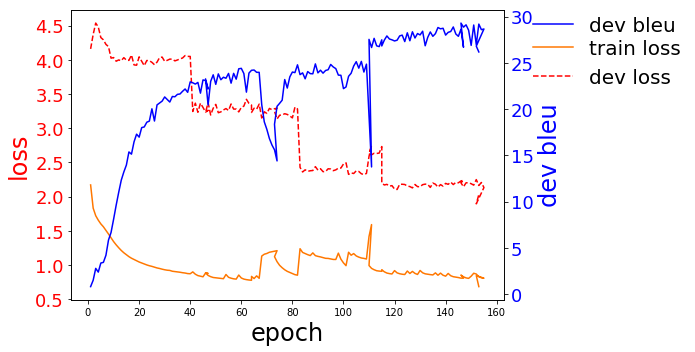

In [9]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8,5)
ax1.plot(log_train[0], log_train[1], color='#ff7700')
ax1.plot(log_test[0], log_test[1], 'r--')
ax1.set_xlabel('epoch', size=24)
ax1.set_ylabel('loss', color='r', size=24)
for tl in ax1.get_yticklabels():
    tl.set_color('r')
    tl.set_fontsize(18)
plt.legend(['train loss', 'dev loss'], bbox_to_anchor=(1.45, 0.96), framealpha=0, fontsize=20)    
ax2 = ax1.twinx()
ax2.plot(log_test[0], log_test[2]*100, 'b-')
ax2.set_xlabel('iteration')
ax2.set_ylabel('dev bleu', color='b', size=24)
# ax1.set_xlim(0, 60)
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    tl.set_fontsize(18) 
plt.legend(['dev bleu'], bbox_to_anchor=(1.44, 1.04), framealpha=0, fontsize=20)
# plt.legend(['dev bleu'], bbox_to_anchor=(1.06, 0.9), framealpha=0, fontsize=20)
plt.grid(False)
plt.tight_layout()

In [10]:
import nltk.translate.bleu_score

In [11]:
def play_utt(utt, m_dict):
    sr, y = scipy.io.wavfile.read(os.path.join(wavs_path, utt.rsplit("-",1)[0]+'.wav'))
    start_t = min(seg['start'] for seg in m_dict[utt]['seg'])
    end_t = max(seg['end'] for seg in m_dict[utt]['seg'])
    print(start_t, end_t)
    start_t_samples, end_t_samples = int(start_t*sr), int(end_t*sr)
    display(Audio(y[start_t_samples:end_t_samples], rate=sr))

In [12]:
def display_words(m_dict, v_dict, preds, utts, dec_key, key, min_len=0, max_len=MAX_EN_LEN, play_audio=False):
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(en.split(" ")) >= min_len and len(en.split(" ")) <= max_len:
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            display_pp = PrettyTable(["cat","sent"], hrules=True)
            display_pp.align = "l"
            display_pp.header = False
            display_pp.add_row(["es ref", textwrap.fill(es,50)])
            display_pp.add_row(["en ref", textwrap.fill(en,50)])
            display_pp.add_row(["en pred", textwrap.fill(p,50)])

            print(display_pp)
            if play_audio:
                play_utt(u, m_dict)
    

In [13]:
def display_words_latex(m_dict, v_dict, preds, utts, dec_key, min_len=0, max_len=2*MAX_EN_LEN):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    es_ref = []
    en_ref = []
    for u in utts:
        es_ref.append(" ".join([w.decode() for w in m_dict[u]['es_w']]))
        if type(m_dict[u][dec_key]) == list:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
        else:
            en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w'][0]]))

    en_pred = []
    join_str = ' ' if dec_key.endswith('_w') else ''

    for p in preds:
        t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
        t_str = t_str[:t_str.find('_EOS')]
        en_pred.append(t_str)

    total_matching_len = 0

    for u, es, en, p in zip(utts, es_ref, en_ref, en_pred):
        if len(es.split(" ")) >= min_len and len(es.split(" ")) <= max_len:
            total_matching_len += 1
            # for reference, 1st word is GO_ID, no need to display
            print("Utterance: {0:s}".format(u))
            print("{0:d} & {1:s} & {2:s} & {3:s} \\\\".format(total_matching_len, es, en, p))

    print("total utts matching length filters={0:d}".format(total_matching_len))

In [14]:
def write_predictions_to_file(m_dict, v_dict, preds, utts, dec_key, key, 
                              min_len=0, max_len=2*MAX_EN_LEN, stemmify=False):
    print("min length={0:d}, max length={1:d}".format(min_len, max_len))
    en_hyp = []
    en_ref = []
    ref_key = 'en_w' if 'en_' in dec_key else 'es_w'
    src_key = 'es_w'
    
#     if stemmify:
#         stemmer = SnowballStemmer("english")
    
    for u in tqdm(utts, ncols=80):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            if type(m_dict[u][ref_key]) == list:
                if stemmify:
                    en_ref.append(" ".join([stem(w.decode()) for w in m_dict[u]['en_w']]))
                else:
                    en_ref.append(" ".join([w.decode() for w in m_dict[u]['en_w']]))
            else:
                en_r_list = []
                for r in m_dict[u][ref_key]:
                    if stemmify:
                        en_r_list.append(" ".join([stem(w.decode()) for w in r]))
                    else:
                        en_r_list.append(" ".join([w.decode() for w in r]))
                en_ref.append(en_r_list)

    join_str = ' ' if dec_key.endswith('_w') else ''

    total_matching_len = 0

    for u, p in zip(utts, preds):
        if len(m_dict[u][src_key]) >= min_len and len(m_dict[u][src_key]) <= max_len:
            total_matching_len += 1
            if stemmify:
                t_str = join_str.join([stem(v_dict['i2w'][i].decode()) if i != EOS_ID else EOS.decode() for i in p])
            else:
                t_str = join_str.join([v_dict['i2w'][i].decode() for i in p])
            t_str = t_str[:t_str.find('_EOS')]
            en_hyp.append(t_str)


    print("total utts matching length filters={0:d}".format(total_matching_len))
    
    with open("{0:s}_mt-output".format(key), "w") as pred_f:
        for p in en_hyp:
            pred_f.write("{0:s}\n".format(p))
        # end for
    # end while
    
    if type(m_dict[utts[0]][ref_key]) == list:
        with open("{0:s}.ref0".format(key), "w") as ref_f:
            for r in en_ref:
                ref_f.write("{0:s}\n".format(r))
    else:
        num_ref = len(m_dict[u][ref_key])
        for i in range(num_ref):
            with open("{0:s}_en.ref{1:d}".format(key,i), "w") as ref_f:
                for r in en_ref:
                    ref_f.write("{0:s}\n".format(r[i]))
                # end for each utt
            # end with
        # end for reference
    # end else
    print("done")
    return en_ref, en_hyp

### Fisher dev

In [56]:
key='fisher_dev'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 50

In [17]:
cat_speech_path = os.path.join(out_path, key)
wavs_path = os.path.join(out_path, "wavs")

In [18]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
fsh_pred_sents, fsh_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True, mini=False)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

  0%|                                                  | 0/3977 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
EPOCH = 152


b=6,l=4.79,avg=2.39: 100%|██████████████████| 3977/3977 [04:27<00:00,  5.82it/s]

********** dev mean loss=2.3869
-
--------------------------------------------------------------------------------


In [150]:
# Eval parameters
ref_index = -1
min_len, max_len= 0, MAX_EN_LEN
displayN = 50

In [151]:
display_words(m_dict, v_dict, fsh_pred_sents[:displayN], fsh_utts[:displayN], 
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

Utterance: 20051017_220530_275_fsp-A-6
+---------+------------------------+
| es ref  | ¿ya eres papá otra vez |
+---------+------------------------+
| en ref  | you are a father again |
+---------+------------------------+
| en pred | are you already father |
+---------+------------------------+
Utterance: 20051022_180817_311_fsp-B-33
+---------+---------+
| es ref  | sí sí   |
+---------+---------+
| en ref  | yes yes |
+---------+---------+
| en pred | yes yes |
+---------+---------+
Utterance: 20051023_232057_325_fsp-B-91
+---------+-----+
| es ref  | ajá |
+---------+-----+
| en ref  | aha |
+---------+-----+
| en pred | aha |
+---------+-----+
Utterance: 20051017_234550_276_fsp-A-1
+---------+-----------------+
| es ref  | ¡ buenas noches |
+---------+-----------------+
| en ref  | good night      |
+---------+-----------------+
| en pred | good evening    |
+---------+-----------------+
Utterance: 20051024_181110_329_fsp-B-100
+---------+-------------+
| es ref  | pero sí sí  |


In [152]:
os.chdir("..")
os.chdir("/afs/inf.ed.ac.uk/group/project/lowres/work/chainer2/speech2text")

In [153]:
b, chrf, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              fsh_pred_sents, 
                              fsh_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

# chrf = [0]*4

# for ref_i in range(4):
#     _, chrf[ref_i], _, _ = calc_bleu(m_dict, 
#                               v_dict, 
#                               fsh_pred_sents[:n], 
#                               fsh_utts[:n], 
#                               dec_key, 
#                               min_len=min_len, 
#                               max_len=max_len, 
#                               ref_index=ref_i)
#     # end for

# # print chrf score
# for i in range(4):
#     print("CHRF score on: {0:s} = {1:.2f}, using reference = {2:d}".format(key, chrf[i] * 100, i))

# print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 42300.74it/s]

min length=0, max length=120
total utts matching length filters=3977


BLEU score on: fisher_dev = 29.02
------------------------------------------------------------


In [154]:
# list(zip(h,r[:5]))

In [155]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [156]:
# print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
# for weights in all_weights:
#     b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
#     print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [157]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.50 |    37.33|    22.19 |    13.39
recall     |    62.44 |    36.08|    21.42 |    12.90


In [158]:
pred_path = "/afs/inf.ed.ac.uk/group/project/lowres/work/installs/fisher-callhome-corpus/corpus/ldc"
pred_fname = os.path.join(pred_path, "fisher_dev.pred")

In [159]:
en_ref, en_hyp = write_predictions_to_file(m_dict, v_dict, fsh_pred_sents, fsh_utts, 
                                           dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

100%|████████████████████████████████████| 3977/3977 [00:00<00:00, 45430.21it/s]

min length=0, max length=120
total utts matching length filters=3977


done


In [160]:
stem('tion')

'tion'

In [161]:
len(en_ref),len(en_hyp)

(3977, 3977)

### Callhome dev

In [ ]:
key='callhome_devtest'
train=False
m_dict = map_dict[key]
v_dict = vocab_dict[dec_key]
n=len(map_dict[key])
BATCH_SIZE = 32

In [ ]:
cat_speech_path = os.path.join(out_path, key)

In [ ]:
print("-"*80)
print("EPOCH = {0:d}".format(last_epoch+1))
call_pred_sents, call_utts, loss = feed_model(map_dict[key],
                  b_dict=bucket_dict[key],
                  vocab_dict=vocab_dict,
                  batch_size=BATCH_SIZE,
                  x_key=enc_key,
                  y_key=dec_key,
                  train=train,
                  cat_speech_path=cat_speech_path, use_y=True)

print("{0:s} {1:s} mean loss={2:.4f}".format("*" * 10,
                                    "train" if train else "dev",
                                    loss))
print("-")
print("-"*80)

In [ ]:
display_words(m_dict, v_dict, call_pred_sents[:displayN], call_utts[:displayN],
              dec_key, key, min_len=min_len, max_len=max_len, play_audio=False)

In [ ]:
b, _, h, r = calc_bleu(m_dict, 
                              v_dict, 
                              call_pred_sents, 
                              call_utts, 
                              dec_key, 
                              min_len=min_len, 
                              max_len=max_len, 
                              ref_index=ref_index)

print("BLEU score on: {0:s} = {1:.2f}".format(key, b * 100))
print("-"*60)

all_weights=[(1.,0.,0.,0.),
             (0.,1.,0.,0.),
             (0.,0.,1.,0.),
             (0.,0.,0.,1.),
             (1./2,1./2,0.,0.),
             (1./3,1./3,1./3,0.),
             (.25,.25,.25,.25)]

In [ ]:
smooth_fun = nltk.translate.bleu_score.SmoothingFunction()

In [ ]:
print("{0:>20s} | {1:20s}".format("bleu score (0-100)", "uni-bi-tri-quad"))
for weights in all_weights:
    b = corpus_bleu(r, h, weights=weights, smoothing_function=smooth_fun.method2)
    print("{0:20.2f} | {1:20s}".format(b * 100, "-".join(map("{0:.2f}".format, weights))))

In [ ]:
_, _ = corpus_precision_recall(r, h)

In [ ]:
call_en_ref, call_en_hyp = write_predictions_to_file(m_dict, v_dict, call_pred_sents, call_utts, 
                                                     dec_key, key, min_len=min_len, max_len=max_len, stemmify=False)

In [ ]:
len(call_en_ref),len(call_en_hyp)

### Google metrics

In [162]:
google_s2t_path_hyps = "./google-s2t/e2e_ast_decode/hyps/fisher_dev/"
google_s2t_path_refs = "./google-s2t/e2e_ast_decode/refs/fisher_dev/"

In [163]:
ref_lines = []
for fname in os.listdir(google_s2t_path_refs):
    with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
        ref_lines.append([line.rstrip('\n').split() for line in in_f])

In [164]:
with open(os.path.join(google_s2t_path_hyps,'fisher_spa_eng_ast_003_base_r0.txt'), "r") as in_f:
    hyps = list(line.rstrip('\n').split() for line in in_f)

In [165]:
refs = []
for i in range(len(ref_lines[0])):
    refs.append([ref_lines[0][i], ref_lines[1][i], ref_lines[2][i], ref_lines[3][i]])

In [166]:
corpus_bleu(refs, hyps)

0.4520259607446546

In [167]:
for i in range(len(refs[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([ref[i] for ref in refs], hyps)))

chrf score using ref:1 = 0.667
chrf score using ref:2 = 0.637
chrf score using ref:3 = 0.622
chrf score using ref:4 = 0.592


In [168]:
for i in range(len(r[0])):
    print("chrf score using ref:{0:d} = {1:5.3f}".format(i+1, corpus_chrf([x[i] for x in r], h)))

chrf score using ref:1 = 0.381
chrf score using ref:2 = 0.444
chrf score using ref:3 = 0.372
chrf score using ref:4 = 0.373


In [169]:
_, _ = corpus_precision_recall(refs, hyps)

min length=0, max length=240
total utts=3979
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    76.60 |    53.98|    38.00 |    26.57
recall     |    76.08 |    53.60|    37.72 |    26.37


In [170]:
_, _ = corpus_precision_recall(r, h)

min length=0, max length=240
total utts=3977
metric     |   1-gram |   2-gram|   3-gram |   4-gram
------------------------------------------------------
precision  |    64.50 |    37.33|    22.19 |    13.39
recall     |    62.44 |    36.08|    21.42 |    12.90


### Prep Google data

In [171]:
kaldi_segment_map_path = os.path.join(out_path,'kaldi_segment_map.dict')
rev_map_dict_path = os.path.join(out_path,'rev_map.dict')
kaldi_segment_map = pickle.load(open(kaldi_segment_map_path, "rb"))
rev_map_dict = pickle.load(open(rev_map_dict_path, "rb"))


google_s2t_path_mapping = "./google-s2t/e2e_ast_decode/mapping/fisher_dev/"
google_s2t_ref0 = os.path.join(google_s2t_path_mapping, "sorted-normalized-fisher_dev.en.0.mapping")

google_s2t_map_path = os.path.join(out_path, "google_s2t_map.dict")
google_s2t_rev_map_path = os.path.join(out_path, "google_s2t_rev_map.dict")
google_s2t_refs_path = os.path.join(out_path, "google_s2t_refs.dict")
google_s2t_hyps_path = os.path.join(out_path, "google_s2t_hyps.dict")

In [172]:
def prep_google_data():

    google_s2t_map = {}
    google_s2t_rev_map = {}

    r_m_dict = rev_map_dict['fisher_dev']
    with open(google_s2t_ref0, "r") as in_f:
        for i, line in enumerate(in_f, start=1):
            wav_f = line.split(".wav")[0].replace("fisher_dev/", "")
            key_1 = wav_f[:wav_f.find("_fsp")+len("_fsp")]
            key_2 = wav_f.rsplit("_fsp",1)[1].split("_")[0]
            google_s2t_map[i] = r_m_dict[key_1+key_2]
            google_s2t_rev_map[r_m_dict[key_1+key_2]] = i
        # end for
    # end with
    pickle.dump(google_s2t_map, open(google_s2t_map_path, "wb"))
    pickle.dump(google_s2t_rev_map, open(google_s2t_rev_map_path, "wb"))
    
    google_s2t_refs = {}
    for fname in os.listdir(google_s2t_path_refs):
        with open(os.path.join(google_s2t_path_refs,fname), "r") as in_f:
            f_key = fname.rsplit("-",1)[-1].replace(".en.","_ref_")
            google_s2t_refs[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_refs[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_refs, open(google_s2t_refs_path, "wb"))
    
    google_s2t_hyps = {}
    for fname in os.listdir(google_s2t_path_hyps):
        with open(os.path.join(google_s2t_path_hyps,fname), "r") as in_f:
            f_key = "fisher_dev_{0:s}".format(fname.rsplit("_")[-1].replace(".txt", ""))
            google_s2t_hyps[f_key] = {}
            for i, line in enumerate(in_f, start=1):
                utt_key = google_s2t_map[i]
                google_s2t_hyps[f_key][utt_key] = line.rstrip('\n').split()
            # end for
        # end with
    # end for
    pickle.dump(google_s2t_hyps, open(google_s2t_hyps_path, "wb"))
    return google_s2t_refs, google_s2t_hyps

In [173]:
"." in fsh_utts

False

In [174]:
def write_google_s2t_refs_to_file(google_dict, utts):
    for r in google_dict.keys():
        out_fname = "google_"+r+".en"
        with open(out_fname, "w") as out_f:
            print("writing to file: {0:s}".format(out_fname))
            for utt_id in utts:
                words = " ".join(google_dict[r][utt_id])
                out_line = "{0:s}\n".format(words)
                out_f.write(out_line)
        # end for
    # end with

In [175]:
google_s2t_refs, google_s2t_hyps = prep_google_data()

In [176]:
write_google_s2t_refs_to_file(google_s2t_refs, fsh_utts)
write_google_s2t_refs_to_file(google_s2t_hyps, fsh_utts)

writing to file: google_fisher_dev_ref_3.en
writing to file: google_fisher_dev_ref_2.en
writing to file: google_fisher_dev_ref_1.en
writing to file: google_fisher_dev_ref_0.en
writing to file: google_fisher_dev_r2.en
writing to file: google_fisher_dev_r1.en
writing to file: google_fisher_dev_r0.en


In [177]:
" ".join(map(lambda t: t.decode(), m_dict[rev_map_dict['fisher_dev']['20051009_182032_217_fsp.108']]['en_w'][0]))

'and my dad always taught us that that for you to be to believe in god you don t have to be involved with a church'

In [179]:
print(" ".join([w for w in google_s2t_refs['fisher_dev_ref_0'][fsh_utts[0]]]))
print(" ".join([w for w in google_s2t_hyps['fisher_dev_r0'][fsh_utts[0]]]))
print(" ".join([w for w in h[0]]))

you are a father again
you are already dad again
are you already father


In [181]:
len(fsh_utts), len(google_s2t_refs['fisher_dev_ref_0'])

for key in google_s2t_refs['fisher_dev_ref_0']:
    if key not in fsh_utts:
        print(key)
        print(" ".join([w.decode() for w in m_dict[key]['en_w'][0]]))
        print(google_s2t_hyps['fisher_dev_r0']['20051017_220530_275_fsp-B-26'])

20051017_220530_275_fsp-B-21
nothing above in spanish--
['yeah']
20051017_220530_275_fsp-B-26
no words in spanish here lol
['yeah']


In [182]:
google_s2t_refs.keys(), google_s2t_hyps.keys()

(dict_keys(['fisher_dev_ref_3', 'fisher_dev_ref_2', 'fisher_dev_ref_1', 'fisher_dev_ref_0']),
 dict_keys(['fisher_dev_r2', 'fisher_dev_r1', 'fisher_dev_r0']))

In [183]:
[[google_s2t_refs[i][utt_id] for i in google_s2t_refs] for utt_id in fsh_utts][0]

[['are', 'you', 'already', 'a', 'father', 'again'],
 ['are', 'you', 'a', 'dad', 'once', 'again'],
 ['are', 'you', 'a', 'dad', 'again'],
 ['you', 'are', 'a', 'father', 'again']]

In [184]:
google_prec_recall = {'precision' : {}, 'recall' : {}}
model_prec_recall = {'precision' : {}, 'recall' : {}}

for utt_id, ref, hyp in zip(fsh_utts, r, h):
    pval, rval = modified_precision_recall([google_s2t_refs[i][utt_id] for i in google_s2t_refs], 
                                           google_s2t_hyps['fisher_dev_r0'][utt_id], n=1)
    
    google_prec_recall['precision'][utt_id] = float(pval)
    google_prec_recall['recall'][utt_id] = float(rval)
    
    pval, rval = modified_precision_recall(ref, hyp, n=1)
    
    model_prec_recall['precision'][utt_id] = float(pval)
    model_prec_recall['recall'][utt_id] = float(rval)

In [185]:
'20051009_182032_217_fsp-B-10' in model_prec_recall['precision']

True

In [190]:
better_utts = {'precision' : [], 'recall' : []}
for utt_id in fsh_utts:
    if model_prec_recall['precision'][utt_id] > google_prec_recall['precision'][utt_id]:
        better_utts['precision'].append(utt_id)
    if model_prec_recall['recall'][utt_id] > google_prec_recall['recall'][utt_id]:
        better_utts['recall'].append(utt_id)

In [192]:
len(better_utts['precision']), len(better_utts['recall'])

(620, 811)

In [209]:
model_predictions = {}
for u, hyp in zip(fsh_utts, h):
    model_predictions[u] = hyp
print(model_predictions['20051017_220530_275_fsp-A-6'])

['are', 'you', 'already', 'father']


In [215]:
with open("better_precision.txt", "w") as out_f:
    for utt_id in better_utts['precision']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:s}\n".format(utt_id, ref_line, model_pred, google_pred)
        out_f.write(out_line)
    # end for
# end with
with open("better_recall.txt", "w") as out_f:
    out_line = "{0:s}---{1:s}---{2:s}---{3:s}\n".format('utt_id', 'ref_line', 'model_pred', 'google_pred')
    out_f.write(out_line)
    for utt_id in better_utts['recall']:
        ref_line = " ".join([w.decode() for w in m_dict[utt_id]['en_w'][0]])
        model_pred = " ".join(model_predictions[utt_id])
        google_pred = " ".join(google_s2t_hyps['fisher_dev_r0'][utt_id])
        out_line = "{0:s}---{1:s}---{2:s}---{3:s}\n".format(utt_id, ref_line, model_pred, google_pred)
        out_f.write(out_line)
    # end for
# end with
        

In [ ]:
# test_ref = [["ha ha lol hue".split()], ["ha ha ja ha".split()], ["ha ha ja ha".split()]]
# test_h = ["lol ja".split(), "ha he".split(), "ha ja".split()]
# _, _ = corpus_precision_recall(test_ref, test_h)